### Importação das bibliotecas

In [83]:
import pandas as pd
import unicodedata
from pathlib import Path
from datetime import datetime
from typing import Optional, Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Funções auxiliares de pré-processamento

Esta sessão define funções utilitárias fundamentais para preparar os dados antes da análise e modelagem. Elas ajudam a:

- **Remover acentos** de textos para evitar inconsistências em nomes e categorias;
- **Padronizar os nomes das colunas** e o campo `id_discente` para evitar erros durante junções e filtragens;
- **Arredondar valores numéricos** para facilitar leitura e evitar ruído com muitas casas decimais;
- **Agrupar informações por discente**, permitindo criar novas variáveis agregadas, como número de cursos, reprovações, etc.

In [84]:
def remover_acentos(texto: str) -> str:
    return unicodedata.normalize("NFKD", texto).encode("ASCII", "ignore").decode("ASCII")

def padronizar_colunas(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = df.columns.str.strip().str.lower()

    if "id_discente" in df.columns:
        df["id_discente"] = df["id_discente"].astype(str).str.strip().str.lower()

    return df

def arredondar_colunas_numericas(df: pd.DataFrame) -> pd.DataFrame:
    colunas = df.select_dtypes(include=["float", "float64"]).columns
    df[colunas] = df[colunas].round(2)
    return df

def agrupar(df: pd.DataFrame, col: str, nome: str, agg: str = "nunique") -> pd.DataFrame:
    return df.groupby("id_discente")[col].agg(agg).reset_index(name=nome)

Esta função tem como objetivo **normalizar e agrupar descrições de situação de matrícula em categorias padronizadas**. Isso facilita a análise posterior, reduzindo a complexidade das classes possíveis. A categorização segue a seguinte lógica:

- Situações contendo **"APROVADO"** ou **"DISPENSADO"** são classificadas como `"aprovada"`;
- Situações contendo **"REPROVADO"** são classificadas como `"reprovada"`;
- Situações contendo **"TRANCADO"**, **"CANCELADO"** ou **"DESISTÊNCIA"** são classificadas como `"trancada"`;
- Situações contendo **"INDEFERIDO"** são classificadas como `"indeferido"`;
- Qualquer outra descrição ou valor ausente é classificado como `"outros"`.

In [85]:
def categorizar_descricao(descricao: Optional[str]) -> str:
    if pd.isna(descricao):
        return "outros"

    desc = descricao.strip().upper()

    if "APROVADO" in desc or "DISPENSADO" in desc:
        return "aprovada"
    if "REPROVADO" in desc:
        return "reprovada"
    if any(x in desc for x in ["TRANCADO", "CANCELADO", "DESISTENCIA"]):
        return "trancada"
    if "INDEFERIDO" in desc:
        return "indeferido"
    return "outros"

### Carregamento e pré-processamento de dados

Essas funções são responsáveis por **carregar os arquivos CSV brutos** das pastas de entrada e realizar **etapas iniciais de limpeza, padronização e filtragem**. 

#### `carregar_csvs_em_pasta(caminho_pasta: str)`
Lê todos os arquivos `.csv` dentro de uma pasta fornecida e retorna um `DataFrame` único com todos os CSVs concatenados.

#### `carregar_dados_pessoais()`
Carrega os dados pessoais dos discentes a partir da pasta `./dados/dados_pessoais_discentes`:
- Padroniza os nomes das colunas.
- Filtra apenas discentes de **graduação**.
- Renomeia a coluna `"status"` para `"status_do_discente"`.

#### `carregar_matriculas(dados_pessoais: pd.DataFrame)`
Carrega e processa os dados de matrícula:
- Filtra os dados para conter apenas discentes válidos (presentes em `dados_pessoais`).
- Converte colunas como `"media_final"` e `"numero_total_faltas"` para valores numéricos.
- Transforma a coluna `"reposicao"` de string booleana para `0` ou `1`.

#### `carregar_situacoes(dados_pessoais: pd.DataFrame)`
Carrega os dados de situação dos discentes:
- Remove acentos e normaliza o texto da coluna `"situacao"`.
- Retorna apenas situações de discentes válidos.


In [86]:
def carregar_csvs_em_pasta(caminho_pasta: str) -> pd.DataFrame:
    pasta = Path(caminho_pasta)
    arquivos = list(pasta.glob("*.csv"))

    if not arquivos:
        print(f"[AVISO] Nenhum CSV encontrado em {caminho_pasta}")
        return pd.DataFrame()
    
    dfs = []
    
    for arquivo in arquivos:
        try:
            df = pd.read_csv(arquivo, sep=";", encoding="utf-8")
            dfs.append(df)
        except Exception as e:
            print(f"[ERRO] Erro ao ler {arquivo.name}: {e}")
    
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

def carregar_dados_pessoais() -> pd.DataFrame:
    df = carregar_csvs_em_pasta("./dados/dados_pessoais_discentes")
    df = padronizar_colunas(df)
   
    df = df[df["nivel_ensino"].str.upper().str.strip() == "GRADUAÇÃO"]
    df.rename(columns={"status": "status_do_discente"}, inplace=True)
   
    return df

def carregar_matriculas(dados_pessoais: pd.DataFrame) -> pd.DataFrame:
    df = carregar_csvs_em_pasta("./dados/matriculas")
    df.rename(columns={"discente": "id_discente"}, inplace=True)
   
    df = padronizar_colunas(df)
    df = df.loc[:, ~df.columns.duplicated()]
   
    df["media_final"] = pd.to_numeric(df["media_final"].str.replace(",", "."), errors="coerce")
    df["numero_total_faltas"] = pd.to_numeric(df["numero_total_faltas"], errors="coerce")
    df["reposicao"] = pd.to_numeric(df["reposicao"].map({"True": 1, "False": 0}), errors="coerce").fillna(0)
   
    return df[df["id_discente"].isin(dados_pessoais["id_discente"])]

def carregar_situacoes(dados_pessoais: pd.DataFrame) -> pd.DataFrame:
    df = carregar_csvs_em_pasta("./dados/situacao_discentes")
    
    if df.empty:
        return df
    
    df = padronizar_colunas(df)
    df = df[df["id_discente"].isin(dados_pessoais["id_discente"])]
    df["situacao"] = df["situacao"].apply(lambda x: remover_acentos(x.strip().upper()) if pd.notna(x) else x)
    
    return df

### Construção das Features

Nesta etapa, consolidamos diversas informações em um único DataFrame de atributos (`features`) para cada discente. A função `construir_features` realiza as seguintes operações:

- **Dados Pessoais**:
  - Converte o ano de nascimento para tipo numérico.
  - Calcula a idade com base no ano atual.

- **Informações Acadêmicas**:
  - Categoriza as descrições das matrículas em tipos como `aprovada`, `reprovada`, `trancada` etc.
  - Conta o número total de disciplinas cursadas (`disciplinas_cursadas`) por discente.
  - Calcula o número de disciplinas por categoria (`disciplina_aprovada`, `disciplina_reprovada`, etc).
  - Calcula a média geral das notas finais (`media_final_geral`).
  - Soma o total de faltas e de aulas de reposição.

- **Histórico de Situação**:
  - Cria uma variável `semestres_cursados` a partir do histórico de situação do discente.
  - Inclui a última situação acadêmica registrada, por exemplo, “Evadido”, “Formado”, etc.

- **Tratamento de Valores Nulos**:
  - Preenche valores ausentes em colunas numéricas com zero.


In [87]:
def construir_features(dados_pessoais: pd.DataFrame, matriculas: pd.DataFrame, situacoes: pd.DataFrame) -> pd.DataFrame:
    features = dados_pessoais.copy()
    
    features["ano_nascimento"] = pd.to_numeric(features["ano_nascimento"], errors="coerce")
    
    features["idade"] = datetime.now().year - features["ano_nascimento"]
    
    matriculas["categoria"] = matriculas["descricao"].apply(categorizar_descricao)
    features = features.merge(agrupar(matriculas, "id_turma", "disciplinas_cursadas"), on="id_discente", how="left")
    
    categorias = matriculas.pivot_table(
                    index="id_discente", columns="categoria", values="id_turma", aggfunc="nunique", fill_value=0
                ).rename(columns=lambda x: f"disciplina_{x}").reset_index()
    features = features.merge(categorias, on="id_discente", how="left")

    features = features.merge(agrupar(matriculas, "media_final", "media_final_geral", agg="mean"), on="id_discente", how="left")
   
    faltas_unicas = matriculas.groupby(["id_discente", "id_turma"])["numero_total_faltas"].first().reset_index()
   
    features = features.merge(agrupar(faltas_unicas, "numero_total_faltas", "total_faltas", agg="sum"), on="id_discente", how="left")
    features = features.merge(agrupar(matriculas, "reposicao", "total_reposicoes", agg="sum"), on="id_discente", how="left")
   
    situacoes["semestre"] = situacoes["ano_alteracao_situacao"].astype(str) + "." + situacoes["periodo_alteracao_situacao"].astype(str)
    features = features.merge(agrupar(situacoes, "semestre", "semestres_cursados"), on="id_discente", how="left")
    
    ultima_situacao = situacoes.sort_values("data_alteracao_situacao").groupby("id_discente").tail(1)[["id_discente", "situacao"]]
    features = features.merge(ultima_situacao, on="id_discente", how="left")
    
    col_numericas = ["disciplinas_cursadas", "media_final_geral", "total_faltas", "total_reposicoes", "semestres_cursados"]
    features[col_numericas] = features[col_numericas].fillna(0)

    return features

### Criação da variável target (`aluno_evadio`)

Neste bloco, é criada a variável target que será utilizada para treinar o modelo de predição de evasão. A coluna `status_do_discente` é analisada e transformada em uma variável binária chamada `aluno_evadio`. 

A lógica aplicada considera como aluno evadido (`1`) os discentes cujo status contém as palavras **"CANCELADO"** ou **"DESISTENCIA"** (caso haja valor não nulo na coluna). Em todos os outros casos, o valor atribuído é `0`.


In [88]:
def criar_target(df: pd.DataFrame) -> pd.DataFrame:
    df["aluno_evadio"] = df["status_do_discente"].str.upper().apply(lambda x: int("CANCELADO" in x or "DESISTENCIA" in x) if pd.notna(x) else 0)
    return df

### Limpeza de colunas irrelevantes e filtragem de dados

Este bloco realiza a limpeza dos dados, removendo colunas que não são relevantes para a predição da evasão e aplicando alguns filtros de qualidade:

- Remove colunas como localidade, curso, forma de ingresso, tipo de cota e status, que não serão utilizadas como variáveis explicativas.
- A coluna `cotista`, caso exista, é convertida para valores binários (`1` para cotista, `0` para não cotista).
- Alunos com ano de ingresso anterior a 2010 são removidos - há uma limitação nas tabelas de situações dos discentes, que iniciam a partir do ano de 2012, desse modo, havia diversos registros com valores vazios.
- Registros com valores inválidos na coluna `sexo` são descartados (mantém-se apenas "M" e "F").
- Ao final, qualquer linha com valores ausentes é removida com `dropna()`.

In [89]:
def limpar_colunas_irrelevantes(df: pd.DataFrame) -> pd.DataFrame:
    colunas_remover = [
        "estado_origem", "cidade_origem", "estado", "municipio", "bairro", "nivel_ensino",
        "curso", "forma_ingresso", "tipo_cota", "descricao_tipo_cota", "status_do_discente", "situacao"
    ]

    df = df.drop(columns=[col for col in colunas_remover if col in df.columns], errors="ignore")
    
    if "cotista" in df.columns:
        df["cotista"] = df["cotista"].astype(str).str.strip().str.lower().map({"t": 1, "f": 0}).fillna(0).astype(int)
    
    if "ano_ingresso" in df.columns:
        df = df[df["ano_ingresso"] >= 2010]
    
    if "sexo" in df.columns:
        df = df[df["sexo"].isin(["M", "F"])]
    
    return df.dropna()

### Geração final dos dados processados

Este bloco executa todo o pipeline de processamento de dados, consolidando e exportando os dados prontos para análise e modelagem:

In [90]:
def gerar_dados():
    dados_pessoais = carregar_dados_pessoais()
    matriculas = carregar_matriculas(dados_pessoais)
    situacoes = carregar_situacoes(dados_pessoais)

    df = construir_features(dados_pessoais, matriculas, situacoes)
    df = criar_target(df)
    df = limpar_colunas_irrelevantes(df)
    df = arredondar_colunas_numericas(df)
    
    df.to_csv("dados_completos.csv", index=False, sep=";", encoding="utf-8")

gerar_dados()

C:\Users\pedro\AppData\Local\Temp\ipykernel_17872\829541727.py:13: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(arquivo, sep=";", encoding="utf-8")


### Codificação de variáveis categóricas

Nesta etapa, as variáveis categóricas são transformadas em valores numéricos utilizando `LabelEncoder`.

In [91]:
def codificar_variaveis_categoricas(df: pd.DataFrame, colunas: list) -> Tuple[pd.DataFrame, Dict[str, LabelEncoder]]:
    label_encoders = {}

    for col in colunas:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
        
    return df

### Preparação dos dados para o modelo

Antes de treinar o modelo, é necessário separar as variáveis preditoras (`X`) da variável alvo (`y`).  
A função abaixo realiza essa separação:

- Remove colunas irrelevantes para a predição, como `id_discente` e `ano_nascimento`, que não devem influenciar diretamente a evasão.
- Define a variável alvo (`y`) como a coluna `aluno_evadio`, que indica se o estudante evadiu ou não.

In [92]:
def preparar_dados(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    X = df.drop(columns=["id_discente", "aluno_evadio", "ano_nascimento"])
    y = df["aluno_evadio"]
    
    return X, y

### Normalização dos dados

Nessa sessão realizamos a normalização (z-score) dos dados de treino e teste através do `StandardScaler`, que transforma os dados para que tenham média 0 e desvio padrão 1.


In [93]:
def normalizar_dados(X_train: pd.DataFrame, X_test: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    num_cols = X_train.select_dtypes(include=["float64", "int64"]).columns
    scaler = StandardScaler()

    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])
    
    return X_train, X_test

### Treinamento do Modelo

Neste estágio, realizamos o carregamento dos dados, pré-processamento e o treinamento de um modelo de classificação utilizando o modelo RandomForest.

In [94]:
df = pd.read_csv("dados_completos.csv", sep=";")

df = codificar_variaveis_categoricas(df, colunas=["sexo", "raca"])

X, y = preparar_dados(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = normalizar_dados(X_train, X_test)

modelo = RandomForestClassifier(class_weight="balanced", random_state=42)
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

### Avaliação do Modelo

Após o treinamento, avaliamos o desempenho do modelo utilizando métricas clássicas de classificação:

In [95]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Acurácia do modelo: {accuracy:.4f}")

report = classification_report(y_test, y_pred, target_names=["Não Evadiu", "Evadido"], zero_division=0)
print("\n📋 Relatório de Classificação:")
print(report)


✅ Acurácia do modelo: 0.9067

📋 Relatório de Classificação:
              precision    recall  f1-score   support

  Não Evadiu       0.89      0.93      0.91      8590
     Evadido       0.92      0.88      0.90      8068

    accuracy                           0.91     16658
   macro avg       0.91      0.91      0.91     16658
weighted avg       0.91      0.91      0.91     16658



O modelo acertou aproximadamente **90,67%** das previsões totais, indicando um bom desempenho geral na classificação dos alunos como evadidos ou não evadidos.

- **Precision (Precisão):**  
  Para a classe *Não Evadiu*, **89%** das vezes que o modelo previu "não evadiu" estava correto. Para a classe *Evadido*, essa precisão foi de **92%**.  
  Isso indica que o modelo comete menos falsos positivos para a classe *Evadido*.

- **Recall (Sensibilidade):**  
  O recall mede a capacidade do modelo de identificar corretamente os verdadeiros positivos. Para *Não Evadiu*, o modelo recuperou **93%** dos casos reais dessa classe; para *Evadido*, recuperou **88%**.  
  Ou seja, o modelo é um pouco melhor em identificar os alunos que não evadiram do que os que evadiram.

- **F1-score:**  
  Ambos os valores são altos, **0.91** e **0.90**, indicando que o modelo mantém um bom equilíbrio entre evitar falsos positivos e falsos negativos.

- **Support:**  
  Número real de exemplos de cada classe no conjunto de teste, mostra que as classes estão relativamente balanceadas (**8.590** e **8.068**).

C:\Users\pedro\AppData\Local\Temp\ipykernel_17872\165996523.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=features.values[:top_n], y=features.index[:top_n], palette="viridis")


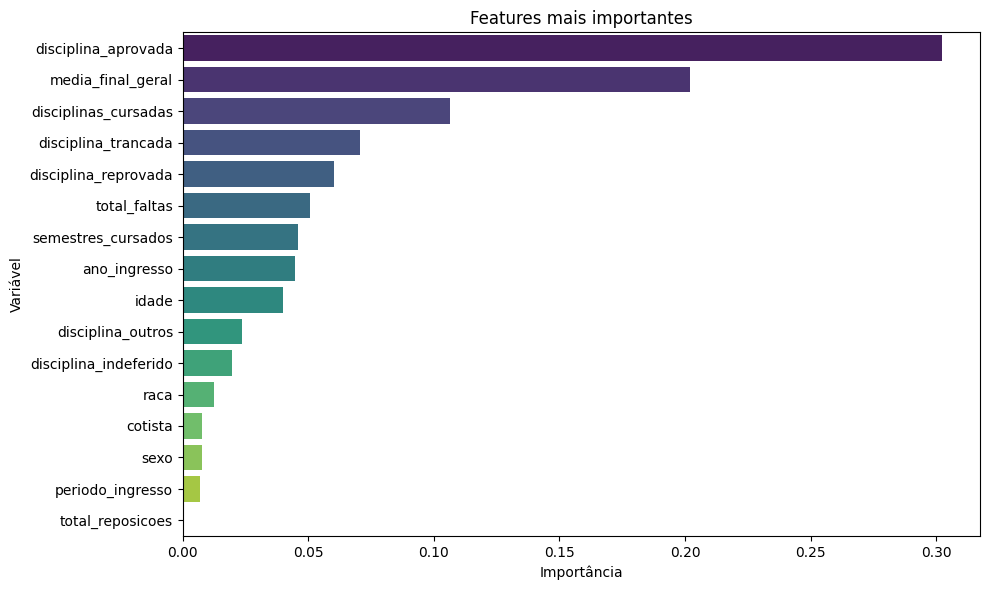

In [96]:
def plotar_importancia_das_features(modelo: RandomForestClassifier, X: pd.DataFrame, top_n: int = 20):
    importancias = modelo.feature_importances_

    features = pd.Series(importancias, index=X.columns).sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=features.values[:top_n], y=features.index[:top_n], palette="viridis")
    
    plt.title(f"Features mais importantes")
    plt.xlabel("Importância")
    plt.ylabel("Variável")
    plt.tight_layout()
    
    plt.show()

plotar_importancia_das_features(modelo, X_train)

- **`disciplina_aprovada`** e **`media_final_geral`** são as variáveis com maior importância para o modelo.
  - Isso indica que alunos com um bom desempenho acadêmico (boas médias e maior número de aprovações) têm menor probabilidade de evadir.
  - O modelo entende que o sucesso nas disciplinas está fortemente associado à permanência.

- **`disciplinas_cursadas`**, **`disciplina_trancada`**, **`disciplina_reprovada`** e **`total_faltas`** também possuem peso relevante.
  - Essas variáveis refletem o **comportamento acadêmico e o nível de engajamento** do estudante.
  - Muitas reprovações, faltas ou trancamentos podem ser sinais de risco de evasão.

- **`semestres_cursados`**, **`ano_ingresso`** e **`idade`** contribuem para o modelo, embora com menor influência.

- Variáveis como **`sexo`**, **`raca`**, **`cotista`**, **`periodo_ingresso`** e **`total_reposicoes`** apresentam impacto quase nulo na previsão.
  - Isso indica que, neste conjunto de dados, **informações demográficas e administrativas têm pouca relevância direta** para prever a evasão.

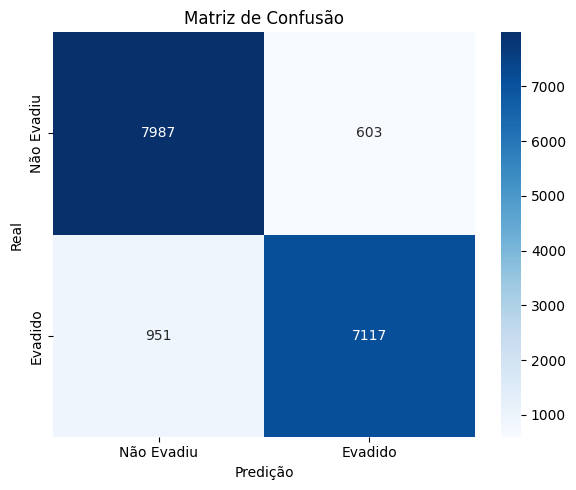

In [97]:
def plotar_matriz_de_confusao(y_true, y_pred, labels=["Não Evadiu", "Evadido"]):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Matriz de Confusão")
    plt.xlabel("Predição")
    plt.ylabel("Real")
    plt.tight_layout()
    plt.show()

plotar_matriz_de_confusao(y_test, y_pred)

- **7987** alunos corretamente classificados como **"Não Evadiu"** (*Verdadeiros Negativos*).
- **7117** alunos corretamente classificados como **"Evadiu"** (*Verdadeiros Positivos*).
- **603** alunos que **não evadiram** foram classificados como **evadidos** (*Falsos Positivos*).
- **951** alunos que **evadiram** foram classificados como **não evadidos** (*Falsos Negativos*).

O modelo apresenta **desempenho robusto** em ambas as classes, com mais acertos do que erros em todos os casos. Além disso, o modelo é ligeiramente melhor em identificar quem **não irá evadir**, mas também é bastante eficaz em prever quem **irá evadir** — ponto crucial para ações preventivas. Os **falsos negativos** (alunos que vão evadir, mas foram previstos como "não evadidos") são os mais críticos, pois podem impedir que a instituição intervenha a tempo. Ainda assim, o número de **951 falsos negativos** é relativamente baixo, o que mostra que o modelo tem bom desempenho **na antecipação de casos de evasão**.

Por fim, o modelo apresenta **alta capacidade preditiva para a evasão**, acertando a maioria dos casos tanto de alunos que permanecem quanto dos que evadem. Isso o torna eficaz para **identificar alunos em risco**, permitindo intervenções mais direcionadas e estratégias institucionais de retenção estudantil.
